In [7]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("data/mq_variants_intensity_cleaned.csv")
df.head()

,Variant,Variant ID,Unmod variant,Total,Total- Unmodified sequence,Variants- Unmodified sequence,Proteins,Mass,Charge,Num Mods,...,_dyn_#Barasertib_HQPA DMSO.Tech replicate 1 of 1,_dyn_#Baricitinib 1000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 100nM.Tech replicate 1 of 1,_dyn_#Baricitinib 10nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3000nM.Tech replicate 1 of 1,_dyn_#Baricitinib 300nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3nM.Tech replicate 1 of 1,_dyn_#Baricitinib DMSO.Tech replicate 1 of 1
0,.VADPDHDHTGFLTEYVATR.,93378,.VADPDHDHTGFLTEYVATR.,11372,15019,62,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,2144.0,2,0,...,0.0,-1.881633,0.756643,0.421505,-1.401957,-1.598584,-0.479360,0.217548,0.098615,0.0
1,.LGEHNIDVLEGNEQFINAAK.,50733,.LGEHNIDVLEGNEQFINAAK.,8878,23098,134,TRYP_PIG,2211.1,2,0,...,0.0,-1.532865,0.076278,0.107261,-1.337973,-1.782213,-1.034816,0.001841,-0.739839,0.0
2,.FRHENIIGINDIIR.,25741,.FRHENIIGINDIIR.,8720,12619,33,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,1709.9,2,0,...,0.0,-1.692048,-0.173765,0.511881,-1.385587,-1.068768,-1.038383,-0.082007,-0.371047,0.0
3,.ESESTAGSFSLSVR.,21292,.ESESTAGSFSLSVR.,7995,8328,7,sp|P06239-2|LCK_HUMAN;sp|P06239-3|LCK_HUMAN;sp...,1456.7,2,0,...,0.0,-0.206927,0.230734,0.508919,0.059995,0.153913,0.582525,-0.194525,-0.012871,0.0
4,.NYLLSLPHK.,68115,.NYLLSLPHK.,7445,11842,41,sp|P28482|MK01_HUMAN,1084.6,2,0,...,0.0,2.405718,3.461120,3.757845,2.516899,2.784061,2.735264,3.449290,3.054920,0.0


In [13]:
def extract_modifications(variant):
    """Extract modifications in the format 'Letter+Number.Number' from variant string."""
    return re.findall(r"([A-Z]\+[0-9]+\.[0-9]+)", variant)


def process_modification_data(df: pd.DataFrame):
    """Process DataFrame to extract modification intensity data for heatmap."""
    # Extract all unique modifications
    all_mods = []
    df["Variant"].dropna().apply(lambda x: all_mods.extend(extract_modifications(x)))
    unique_mods = sorted(set(all_mods))

    drug_columns = [col for col in df.columns if col.startswith("_dyn_#")]
    mod_data = {mod: {drug: [] for drug in drug_columns} for mod in unique_mods}

    for _, row in df.iterrows():
        mods = extract_modifications(row["Variant"])
        for mod in mods:
            for drug_col in drug_columns:
                if pd.notna(row[drug_col]) and row[drug_col] != 0:
                    mod_data[mod][drug_col].append(row[drug_col])

    heatmap_data = pd.DataFrame(0.0, index=unique_mods, columns=drug_columns)
    for mod in unique_mods:
        for drug in drug_columns:
            values = mod_data[mod][drug]
            heatmap_data.loc[mod, drug] = np.median(values) if values else 0

    # Clean column names
    heatmap_data.columns = heatmap_data.columns.str.replace("_dyn_#", "").str.replace(
        ".Tech replicate 1 of 1", ""
    )

    # Sort modifications by abosulute effect
    mod_effect = heatmap_data.abs().sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.loc[mod_effect.index]
    return heatmap_data


heatmap_data = process_modification_data(df)

In [10]:
print(heatmap_data.head())
heatmap_data.to_csv("data/heatmap_data.csv")

          AEE-788_inBT474 1000nM  AEE-788_inBT474 100nM  AEE-788_inBT474 10nM  \
C+57.021                0.268092               0.240722              0.014000   
E+1.977                 0.000000               0.000000              0.000000   
M+31.988                0.000000               0.000000              0.000000   
M+31.987                0.000000               0.000000              0.000000   
W+31.988                0.000000              -0.102107              0.366713   

          AEE-788_inBT474 30000nM  AEE-788_inBT474 3000nM  \
C+57.021                -0.328691                0.451026   
E+1.977                  0.000000                0.000000   
M+31.988                 0.000000                0.000000   
M+31.987                 0.000000                0.000000   
W+31.988                -0.218610               -0.607051   

          AEE-788_inBT474 300nM  AEE-788_inBT474 30nM  AEE-788_inBT474 3nM  \
C+57.021               0.273123             -0.484392            -0.

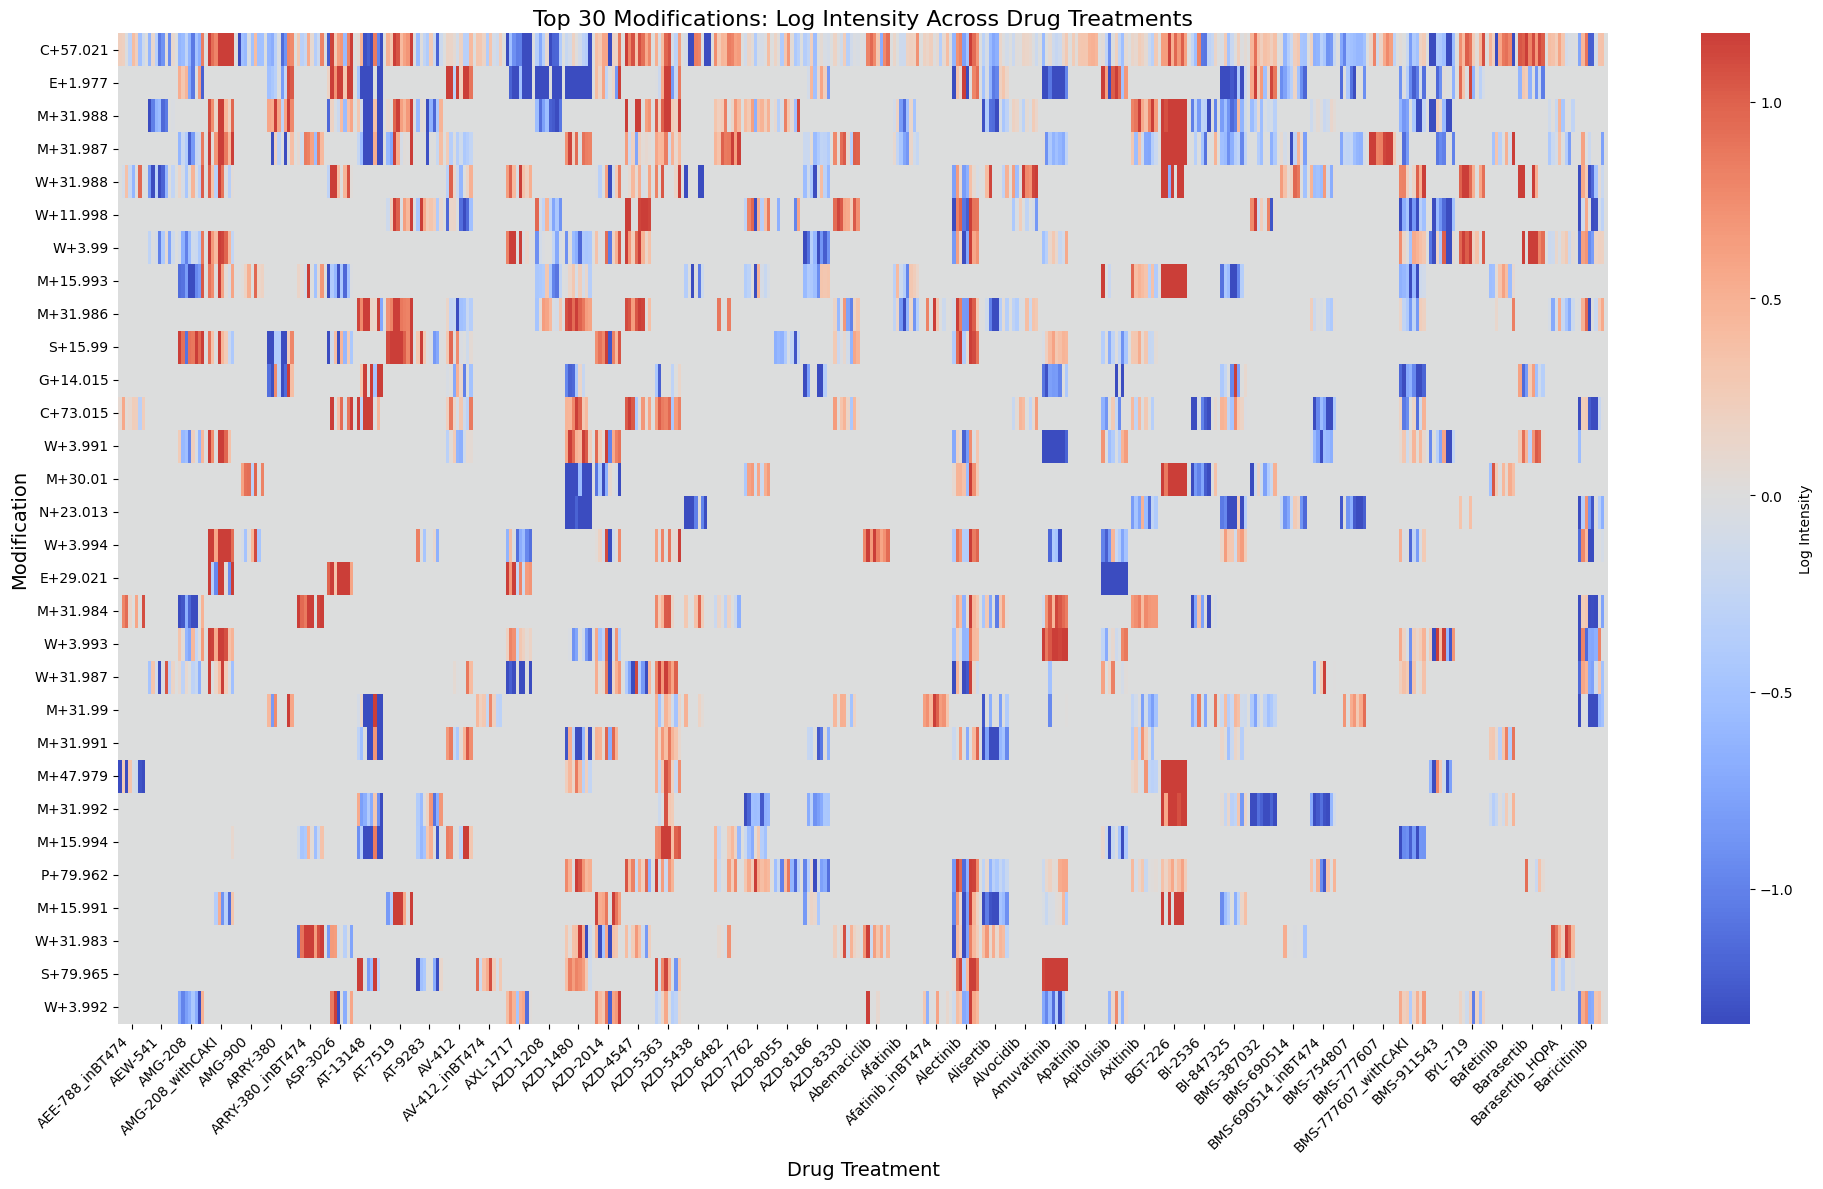

In [14]:
# Get the top 30 modifications
top_n = 30
top_mods = heatmap_data.iloc[:top_n]

# Extract unique drug names (removing concentrations and duplicates)
drug_names = [col.split()[0] for col in top_mods.columns]
unique_drugs = pd.Series(drug_names).drop_duplicates(keep="first")

# Calculate positions for drug labels (center of each drug group)
drug_positions = []
for drug in unique_drugs:
    positions = [i for i, name in enumerate(drug_names) if name == drug]
    center_pos = (positions[0] + positions[-1]) / 2
    drug_positions.append(center_pos)

# Create heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(
    top_mods,
    cmap="coolwarm",
    center=0,
    robust=True,
    xticklabels=False,
    yticklabels=True,
    cbar_kws={"label": "Log Intensity"},
)

plt.title(
    "Top 30 Modifications: Log Intensity Across Drug Treatments",
    fontsize=16,
)
plt.xlabel("Drug Treatment", fontsize=14)
plt.ylabel("Modification", fontsize=14)
plt.xticks(drug_positions, unique_drugs, rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
print(top_mods.head())

          AEE-788_inBT474 1000nM  AEE-788_inBT474 100nM  AEE-788_inBT474 10nM  \
C+57.021                0.268092               0.240722              0.014000   
E+1.977                 0.000000               0.000000              0.000000   
M+31.988                0.000000               0.000000              0.000000   
M+31.987                0.000000               0.000000              0.000000   
W+31.988                0.000000              -0.102107              0.366713   

          AEE-788_inBT474 30000nM  AEE-788_inBT474 3000nM  \
C+57.021                -0.328691                0.451026   
E+1.977                  0.000000                0.000000   
M+31.988                 0.000000                0.000000   
M+31.987                 0.000000                0.000000   
W+31.988                -0.218610               -0.607051   

          AEE-788_inBT474 300nM  AEE-788_inBT474 30nM  AEE-788_inBT474 3nM  \
C+57.021               0.273123             -0.484392            -0.